In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Preparing the dataset

As a first step, let us load the full dataset. It will be helpful to simplify the 'position' column by designating the first position listed as a player's main position.

In [16]:
compressed_fifa_ratings = pd.read_csv('compressed_player_rating_dataset.csv', encoding='latin-1')
# compressed_fifa_ratings.set_index('player_url', inplace=True)

parsed_positions = compressed_fifa_ratings['position'].str.split(' ', expand=True)
parsed_positions.columns = ['main_position', 'position_2', 'position_3', 'position_4']
compressed_fifa_ratings = pd.concat([compressed_fifa_ratings, parsed_positions], axis=1)

compressed_fifa_ratings.drop(['Unnamed: 0', 'position'], axis=1, inplace=True)
compressed_fifa_ratings.head(5)

,player_url,age,overall,potential,team,team_id,nationality,rating_date,main_position,position_2,position_3,position_4
0,/player/10/patrick-deman/,44,52,52,KV Kortrijk,/team/100081/kv-kortrijk/,Belgium,2013-10-25,GK,None,None,None
1,/player/1000/marko-rehmer/,34,75,79,Eintracht Frankfurt,/team/1824/eintracht-frankfurt/,Germany,2006-08-30,CB,None,None,None
2,/player/100033/stijn-stijnen/,25,70,78,Club Brugge KV,/team/231/club-brugge-kv/,Serbia,2006-08-30,GK,None,None,None
3,/player/100033/stijn-stijnen/,25,70,78,Club Brugge KV,/team/231/club-brugge-kv/,Belgium,2007-02-22,GK,None,None,None
4,/player/100033/stijn-stijnen/,26,71,73,Club Brugge KV,/team/231/club-brugge-kv/,Belgium,2007-08-30,GK,None,None,None


#### Aging Curves

Now that we have our raw dataset ready to go, let us spend a moment discussing the methodology we will use to produce an 'aging curve'. The preferred method of calculating the aging curve has long been the 'delta method', described in the link below:
https://www.fangraphs.com/tht/how-do-baseball-players-age-part-1/

Broadly, the delta method compares how individual players perform in back-to-back years. This information is then aggregated to produce an average change in performance over the course of a typical career.

In [17]:
just_overall_ratings = compressed_fifa_ratings[['player_url', 'age', 'main_position', 'overall']].drop_duplicates()
just_overall_ratings['age_next_year'] = just_overall_ratings['age'].apply(lambda x: x+1)
year_over_year_ratings = pd.merge(just_overall_ratings, just_overall_ratings, left_on=['player_url', 'age_next_year'],
                                  right_on=['player_url', 'age'], how='left').drop_duplicates()
year_over_year_ratings = year_over_year_ratings[['player_url', 'main_position_x', 'age_x', 'age_next_year_x', 'overall_x', 'overall_y']]
year_over_year_ratings.columns = ['player_url', 'main_position', 'age', 'age_next_year', 'overall', 'next_year_overall']
year_over_year_ratings.dropna(inplace=True)

year_over_year_ratings['diff'] = year_over_year_ratings['next_year_overall'] - year_over_year_ratings['overall']

To begin with, let us create the average aging curve for all the players in our dataset. Not all transitions from one age to the next will be sufficiently represented in our dataset. To begin with, let's establish which ages to use as cutoff points when building our aging curves.

In [26]:
year_over_year_ratings['age_couplet'] = year_over_year_ratings['age'].map(str) + '/' + year_over_year_ratings['age_next_year'].map(str)

avg_rating_changes = year_over_year_ratings.groupby(['age_couplet'], as_index=False)['diff'].count().set_index('age_couplet')
avg_rating_changes

,diff
age_couplet,
14/15,1
15/16,83
16/17,3510
17/18,13929
18/19,26323
19/20,34481
20/21,38078
21/22,39227
22/23,39196


It appears that the number of observations drops quite dramatically for age couplets under 16, and for age couplets over 38. As such, we will build our aging curves for players with ratings between 16 and 38.

As a next step, we can construct our first aging curve for the full population of players in our dataset.

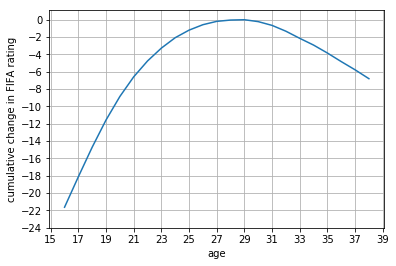

In [214]:
avg_rating_changes = year_over_year_ratings.groupby(['age', 'age_next_year'], as_index=False)['diff'].mean()
avg_rating_changes.columns = ['age', 'age_next_year', 'diff']

avg_rating_changes = avg_rating_changes.loc[(avg_rating_changes['age'] >= 16) & (avg_rating_changes['age'] <= 38)]
avg_rating_changes['cum_sum'] = avg_rating_changes['diff'].cumsum()
maximum_rating = avg_rating_changes['cum_sum'].max()
avg_rating_changes['aging_curve_rating'] = avg_rating_changes['cum_sum'] - maximum_rating

plt.plot(avg_rating_changes['age'], avg_rating_changes['aging_curve_rating'])
plt.xlabel('age')
plt.ylabel('cumulative change in FIFA rating')
plt.xticks(np.arange(15, 40, 2))
plt.yticks(np.arange(np.round(min(avg_rating_changes['aging_curve_rating']))-2, np.round(max(avg_rating_changes['aging_curve_rating']))+2, 2))
plt.grid()
plt.show()

We have constructed these age curves to have the cumulative change in FIFA rating max out at 0. This will simplify our analysis later on when we start comparing positions and individuals.

It would appear that players in FIFA reach their peak performance between ages 28 and 29. The 'peak period' seems to last between ages 27 and 30.

#### Aging Curves by Position

A logical extension of this work is to consider how this aging curve might differ by position. Conventional wisdom dictates that goalkeepers have greater longevity than attacking players. Wingers, who are more reliant on speed than players in central positions, may have lower longevity too (unless your name is Arjen Robben).

As a first step, let's make sure that the sample size for every position is large enough to enable the production of an aging curve - if necessary, we can consolidate similar positions.

In [56]:
all_positions = list(set(year_over_year_ratings['main_position']))

for pos in all_positions:
    one_position_only = year_over_year_ratings.loc[year_over_year_ratings['main_position'] == pos]
    print(pos, one_position_only.shape[0]) 

RWB 1913
CF 8852
CDM 36046
LF 527
LM 29398
LB 32398
RW 13317
RF 603
RB 34365
CB 75664
CAM 32945
CM 57095
ST 72360
SW 108
LW 11834
LWB 2013
GK 44824
RM 30068


It appears that certain positions only contain a few observations. RWB, LF, CF, RF, SW and LWB have very relatively samples. We will fold these positions in with the most similar position as follows:

CF (Center Forward) --> ST (Striker)
RWB (Right Wing Back) --> RB (Right Back)
LF (Left Forward) --> LW (Left Winger)
RF (Right Forward) --> RW (Right Winger)
SW (Sweeper) --> CB (Center Back)
LWB (Left Wing Back) --> LB (Left Back)

In [62]:
position_mapping = {'CF': 'ST', 'RWB': 'RB', 'LF': 'LW', 'RF': 'RW', 'SW': 'CB', 'LWB': 'LB'}

year_over_year_ratings['edited_position'] = year_over_year_ratings['main_position'].replace(position_mapping)
year_over_year_ratings.head()

,player_url,main_position,age,age_next_year,overall,next_year_overall,diff,age_couplet,edited_position
2,/player/100033/stijn-stijnen/,GK,25,26,70,71.0,1.0,25/26,GK
3,/player/100033/stijn-stijnen/,GK,26,27,71,73.0,2.0,26/27,GK
4,/player/100033/stijn-stijnen/,GK,27,28,73,73.0,0.0,27/28,GK
5,/player/100033/stijn-stijnen/,GK,27,28,73,72.0,-1.0,27/28,GK
6,/player/100033/stijn-stijnen/,GK,28,29,73,73.0,0.0,28/29,GK


C:\Users\roald\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\roald\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


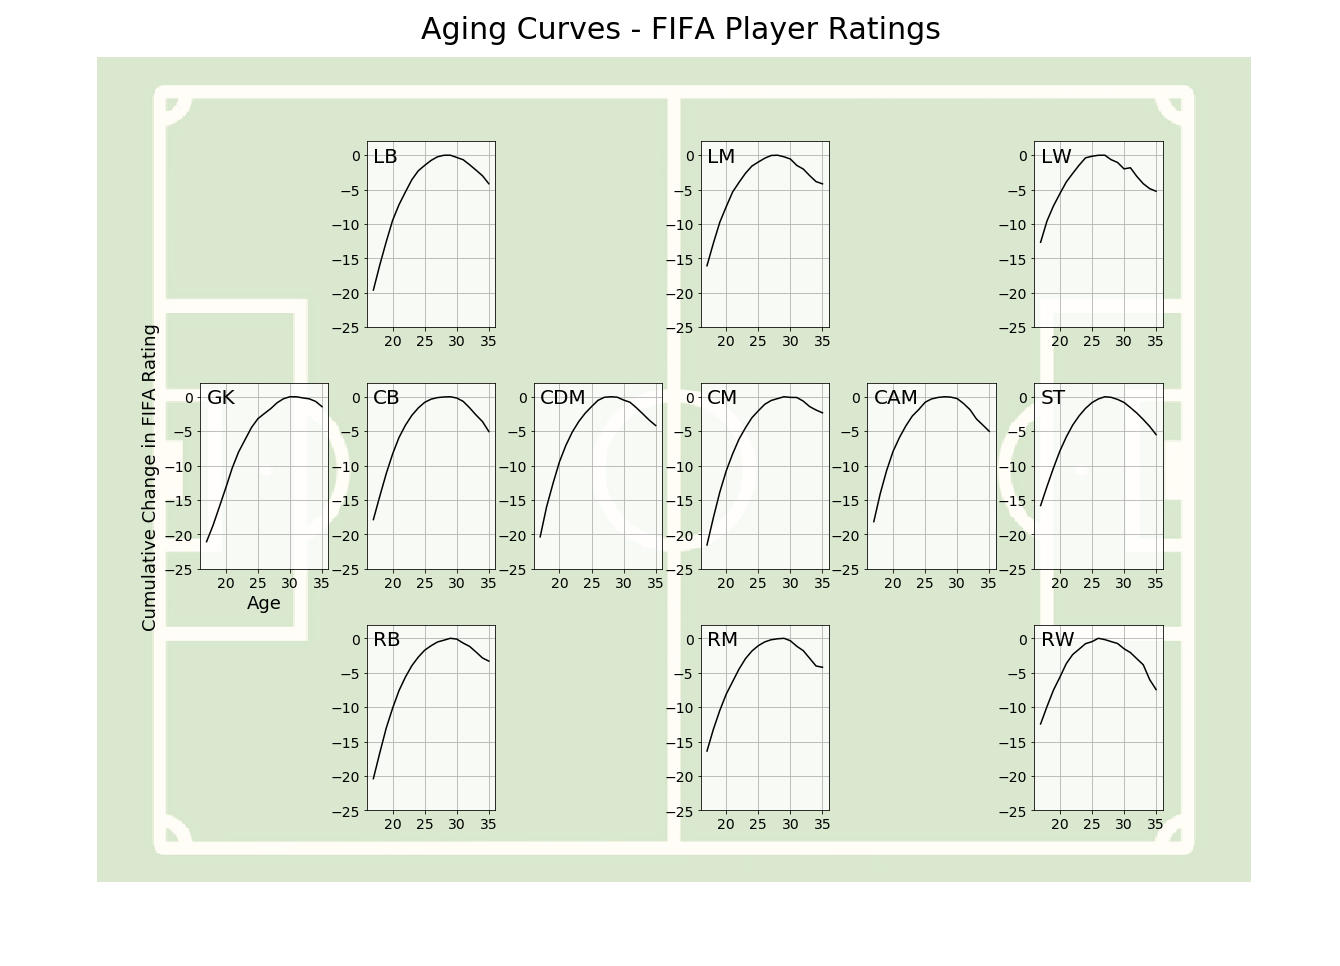

In [226]:
avg_rating_changes = year_over_year_ratings.groupby(['age', 'age_next_year', 'edited_position'], as_index=False)['diff'].mean()
avg_rating_changes.columns = ['age', 'age_next_year', 'edited_position', 'diff']
avg_rating_changes = avg_rating_changes.loc[(avg_rating_changes['age'] >= 17) & (avg_rating_changes['age'] <= 35)]

# all_positions = list(set(avg_rating_changes['edited_position']))
# print(all_positions)

number_of_rows = 5
number_of_columns = 8
all_positions = {'GK': [number_of_rows, number_of_columns, 18], 
                 'RB': [number_of_rows, number_of_columns, 27], 
                 'CB': [number_of_rows, number_of_columns, 19], 
                 'LB': [number_of_rows, number_of_columns, 11], 
                 'CDM': [number_of_rows, number_of_columns, 20], 
                 'RM': [number_of_rows, number_of_columns, 29], 
                 'CM': [number_of_rows, number_of_columns, 21], 
                 'LM': [number_of_rows, number_of_columns, 13], 
                 'CAM': [number_of_rows, number_of_columns, 22], 
                 'RW': [number_of_rows, number_of_columns, 31], 
                 'ST': [number_of_rows, number_of_columns, 23], 
                 'LW': [number_of_rows, number_of_columns, 15],
                }

fig = plt.figure(figsize=(18, 16))
img = plt.imread("soccer_pitch_border.png")
plt.imshow(img)
plt.axis('off')

for key, value in all_positions.items():
#     print(key, value)
    position = avg_rating_changes.loc[avg_rating_changes['edited_position'] == key]
    position['cum_sum'] = position['diff'].cumsum()
    maximum_cumsum = position['cum_sum'].max()
    position['aging_rating'] = position['cum_sum'] - maximum_cumsum
    
    peak = position.loc[position['aging_rating'] == 0]['age']
    peak = peak.iloc[0]
    
    ax = fig.add_subplot(value[0], value[1], value[2])
    ax.patch.set_facecolor('white')
    ax.patch.set_alpha(0.8)
    ax.plot(position['age'], position['aging_rating'], color='black')
    
    ax.text(17, -1, key, fontsize=20)
#     ax.text(18, -29, 'Peak = {}'.format(peak), fontsize=20)
    
    ax.set_xlim(16, 36)
    ax.set_ylim(-25, 2)
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    
    if key == 'GK':
        ax.set_xlabel('Age', fontsize=18)
        ax.set_ylabel('Cumulative Change in FIFA Rating', fontsize=18)
    
    plt.grid()

fig.suptitle('Aging Curves - FIFA Player Ratings', y=0.9, fontsize=30)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.3)
plt.show()

At a glance, we can immediately start to draw some interesting conclusions:

-  Goalkeepers peak later than players in any other position (between ages 29 and 32)
-  Attacking players peak earlier than defensive players - especially wingers
-  Wingers start their careers much closer to their peak than central (and especially defensive) players. This implies that it may be easier to detect talent among wide attacking players than, for instance, goalkeepers